In [1]:
!pip install implicit

     |████████████████████████████████| 1.1MB 12.6MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419518 sha256=03aba17198376b63ebac84c10f8d627731dbbae8b643e99d14e2cb7acf7a3160
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/GB_Recommendation_systems/Lesson_02/retail_train.csv')
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [5]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result['actual'] = result['actual'].apply(lambda x: list(x))
result.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [7]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [8]:
%%time

items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
result.head(2)

CPU times: user 3.76 s, sys: 28.6 ms, total: 3.79 s
Wall time: 3.8 s


In [9]:
result.head()

,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12187839, 93320, 923559, 1021133, 15596625]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1547254, 1489189, 5592689, 1121335, 1091248]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1029171, 895193, 1325795, 9297545, 12170978]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[13115896, 825075, 7443441, 6919174, 991487]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[971839, 840595, 1074509, 950697, 13133772]"


In [10]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [11]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 111 ms


In [12]:
result.head()

,user_id,actual,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12187839, 93320, 923559, 1021133, 15596625]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1547254, 1489189, 5592689, 1121335, 1091248]","[6534178, 6533889, 1029743, 6534166, 1082185]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1029171, 895193, 1325795, 9297545, 12170978]","[6534178, 6533889, 1029743, 6534166, 1082185]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[13115896, 825075, 7443441, 6919174, 991487]","[6534178, 6533889, 1029743, 6534166, 1082185]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[971839, 840595, 1074509, 950697, 13133772]","[6534178, 6533889, 1029743, 6534166, 1082185]"


### Оценивание
За выполнени каждого задания 1 балл

4 балла -> отл

3 балла -> хор

И тд

### Задание 0. Товар 999999
На вебинаре мы использовали товар 999999 - что это за товар? Зачем он нужен. Используя этот товар мы смещяем качество рекомендаций. В какую сторону? Можно ли удалить этот товар? Уберите этот товар и сравните с качеством на семинаре.

In [13]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

In [14]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [15]:
data_train_top = data_train.loc[data_train['item_id'].isin(top_5000)]
data_train_top.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [16]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id',
                                  columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [17]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [18]:
# %%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [19]:
recs

[(34707, 75614.0),
 (23590, 60381.0),
 (36454, 28271.0),
 (39619, 21721.0),
 (25064, 18600.0)]

In [20]:
result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [21]:
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12187839, 93320, 923559, 1021133, 15596625]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 840361]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1547254, 1489189, 5592689, 1121335, 1091248]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 826249, 995242]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1029171, 895193, 1325795, 9297545, 12170978]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[13115896, 825075, 7443441, 6919174, 991487]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[971839, 840595, 1074509, 950697, 13133772]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 1127831]"


In [22]:
# Заведем фиктивный item_id (если юзер НЕ покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [23]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head()

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820361,820486,820518,820560,820701,820895,821025,821083,821200,821209,821219,821344,...,13512965,13671759,13672065,13777104,13841744,13842088,13842090,13842214,13842224,13877192,13945141,13945244,13987135,14025185,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [25]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 2.78 s, sys: 29.8 ms, total: 2.81 s
Wall time: 2.08 s


In [26]:
%%time

result['itemitem_999999'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 64.3 ms, sys: 826 µs, total: 65.2 ms
Wall time: 66.6 ms


In [27]:
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,itemitem_999999
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12187839, 93320, 923559, 1021133, 15596625]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 840361]","[999999, 1082185, 981760, 1127831, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1547254, 1489189, 5592689, 1121335, 1091248]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 826249, 995242]","[999999, 1082185, 981760, 1098066, 995242]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1029171, 895193, 1325795, 9297545, 12170978]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[999999, 1082185, 981760, 1127831, 995242]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[13115896, 825075, 7443441, 6919174, 991487]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[999999, 1082185, 981760, 1127831, 995242]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[971839, 840595, 1074509, 950697, 13133772]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 1127831]","[999999, 1082185, 981760, 1127831, 1098066]"


In [28]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    precision = flags.sum() / len(recommended_list)
    return precision

print('itemitem', round(result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean(), 5))
print('itemitem_999999', round(result.apply(lambda row: precision_at_k(row['itemitem_999999'], row['actual']), axis=1).mean(), 5))

itemitem 0.15406
itemitem_999999 0.13692


Используя фиктивный item_id под номером 999999(товары не из топ-5000) мы ухудшаем качество рекомендаций

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)
- Придумайте пример 3 весов, посчитайте weighted_random_recommendation для разных весов

In [29]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    items = items_weights['item_id'].values
    weights = items_weights['weight'].values

    recs = np.random.choice(items, size=n, replace=False, p=weights)

    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    return recs.tolist()

Сделайте предсказания

In [30]:
item_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
item_weights['weight'] = item_weights['sales_value']/np.sum(item_weights['sales_value'])
item_weights.head()

,item_id,sales_value,weight
0,202291,81.59,0.000012
1,397896,2862.41,0.000406
2,420647,463.81,0.000066
3,480014,863.41,0.000122
4,545926,58.37,0.000008


In [31]:
%%time

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights=item_weights, n=5))

CPU times: user 373 ms, sys: 0 ns, total: 373 ms
Wall time: 377 ms


In [32]:
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,itemitem_999999,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12187839, 93320, 923559, 1021133, 15596625]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1005186, 6534166, 1079987, 899019]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1547254, 1489189, 5592689, 1121335, 1091248]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 826249, 995242]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 5569230, 6034577, 6534178, 970747]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1029171, 895193, 1325795, 9297545, 12170978]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[999999, 1082185, 981760, 1127831, 995242]","[1135552, 1125278, 999999, 8090440, 6442594]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[13115896, 825075, 7443441, 6919174, 991487]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1029743, 1005186, 1103741, 866878]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[971839, 840595, 1074509, 950697, 13133772]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 1127831]","[999999, 1082185, 981760, 1127831, 1098066]","[1025535, 9802914, 999858, 972445, 6534178]"


In [33]:
def weighted_random_recommendation_log(items_weights_log, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    items = items_weights_log['item_id'].values
    weights = items_weights_log['weight'].values

    recs = np.random.choice(items, size=n, replace=False, p=weights)

    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    return recs.tolist()

In [39]:
item_weights_log = data_train.groupby('item_id')['sales_value'].sum().reset_index()

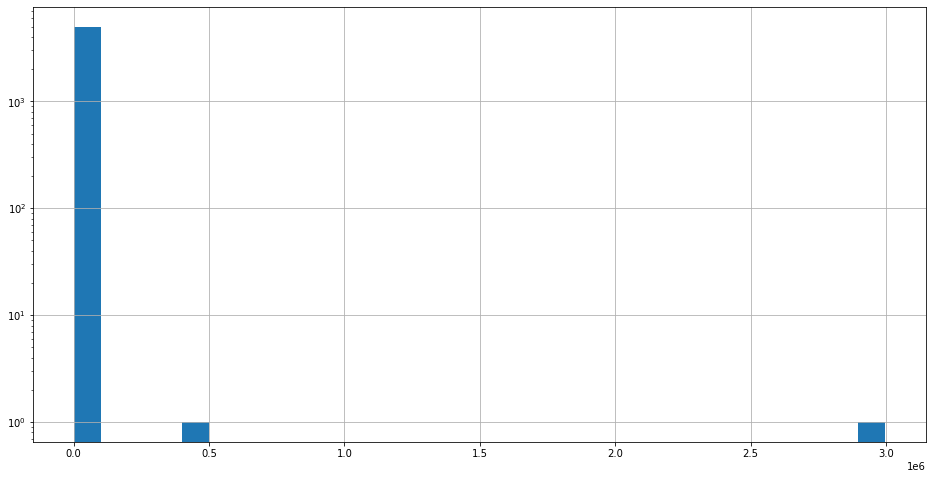

In [40]:
plt.figure(figsize=(16, 8))
item_weights_log['sales_value'].hist(bins=30)
plt.yscale(value="log")
plt.show()

Для того, чтобы функция логарифма от продаж не принимала значение -inf или <=0, необходимо к сумме продаж по товару прибавлять некоторую константу, например 1.1

In [43]:
item_weights_log.loc[item_weights_log['sales_value']>50000, 'sales_value'] = 44779.99
item_weights_log['sales_value_log'] = np.log(item_weights_log['sales_value'] + 1.1)
total = np.sum(item_weights_log['sales_value_log'])
item_weights_log['weight'] = item_weights_log['sales_value_log'] / total
item_weights_log.head()

,item_id,sales_value,weight,sales_value_log
0,202291,81.59,0.000147,4.415099
1,397896,2862.41,0.000265,7.959803
2,420647,463.81,0.000205,6.141844
3,480014,863.41,0.000225,6.762163
4,545926,58.37,0.000136,4.085472


In [44]:
np.sum(item_weights_log['weight'])

0.9999999999999999

In [45]:
%%time

result['weighted_random_recommendation_log'] = result['user_id'].apply(lambda x: weighted_random_recommendation_log(items_weights_log=item_weights_log, n=5))

CPU times: user 290 ms, sys: 1.96 ms, total: 292 ms
Wall time: 295 ms


In [46]:
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,itemitem_999999,weighted_random_recommendation,weighted_random_recommendation_log
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12187839, 93320, 923559, 1021133, 15596625]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1005186, 6534166, 1079987, 899019]","[1046584, 5566472, 889731, 1089108, 1093013]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1547254, 1489189, 5592689, 1121335, 1091248]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 826249, 995242]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 5569230, 6034577, 6534178, 970747]","[1048352, 1031316, 829621, 961846, 1056509]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1029171, 895193, 1325795, 9297545, 12170978]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[999999, 1082185, 981760, 1127831, 995242]","[1135552, 1125278, 999999, 8090440, 6442594]","[1000050, 911614, 954006, 1060529, 8119302]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[13115896, 825075, 7443441, 6919174, 991487]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1029743, 1005186, 1103741, 866878]","[824642, 821344, 835300, 1065331, 7467081]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[971839, 840595, 1074509, 950697, 13133772]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 1127831]","[999999, 1082185, 981760, 1127831, 1098066]","[1025535, 9802914, 999858, 972445, 6534178]","[9194758, 1083770, 10285141, 864033, 993685]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма (с вебинара и weighted_random_recommendation) с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество? Почему?

In [47]:
pd.DataFrame(
    [
        (model_, round(result.apply(lambda row: precision_at_k(recommended_list=row[str(model_)], bought_list=row['actual']), axis=1).mean(), 5)) for model_ in list(result)[2:]
    ], 
    columns=['metric', 'value']
)

,metric,value
0,random_recommendation,0.00049
1,popular_recommendation,0.15524
2,itemitem,0.15406
3,itemitem_999999,0.13692
4,weighted_random_recommendation,0.03281
5,weighted_random_recommendation_log,0.00744


Из всех рассмотренных алгоритмов, подход основанный на популярности товаров popular_recommendation, дал самый высокий precision@5. 

### Задание 3. Улучшение бейзлайнов и ItemItem
 - Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
 - Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей 𝐾.
 - Попробуйте стратегии ансамблирования изученных алгоритмов

In [48]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [49]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [50]:
data_train2 = data_train.loc[data_train['item_id'].isin(top_5000),]

In [51]:
%%time

items = data_train.item_id.unique()
result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

CPU times: user 238 ms, sys: 1.08 ms, total: 239 ms
Wall time: 243 ms


In [52]:
%%time

items = data_train2.item_id.unique()
result['random_recommendation_2'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 241 ms


In [53]:
%%time

popular_recs = popularity_recommendation(data_train, n=5)
result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)

CPU times: user 57.5 ms, sys: 0 ns, total: 57.5 ms
Wall time: 61.7 ms


In [54]:
%%time

popular_recs = popularity_recommendation(data_train2, n=5)
result['popular_recommendation_2'] = result['user_id'].apply(lambda x: popular_recs)

CPU times: user 43 ms, sys: 13.9 ms, total: 56.9 ms
Wall time: 58.5 ms


In [55]:
pd.DataFrame([
    result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean(),
    result.apply(lambda row: precision_at_k(row['random_recommendation_2'], row['actual']), axis=1).mean(),
    result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean(),
    result.apply(lambda row: precision_at_k(row['popular_recommendation_2'], row['actual']), axis=1).mean(),
], 
    columns=['precision_at_k'], 
    index=['random_recommendation', 'random_recommendation_5к', 'popular_recommendation', 'popular_recommendation_5к']
).T

,random_recommendation,random_recommendation_5к,popular_recommendation,popular_recommendation_5к
precision_at_k,0.005779,0.004995,0.085602,0.15524


In [56]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns = ['user_id', 'actual']

In [57]:
%%time

for k in range(1, 10):
    
    model = ItemItemRecommender(K=k, num_threads=4)  # K - кол-во билжайших соседей
    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)
    
    recs = model.recommend(
        userid=userid_to_id[2],  # userid - id от 0 до N
        user_items=csr_matrix(user_item_matrix).tocsr(),  # на вход user-item matrix
        N=5,  # кол-во рекомендаций 
        filter_already_liked_items=False,
        filter_items=None,
        recalculate_user=True)
    
    result[f'itemitem_K={k}'] = result['user_id'].\
        apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                        model.recommend(userid=userid_to_id[x], 
                                        user_items=sparse_user_item,   # на вход user-item matrix
                                        N=5, 
                                        filter_already_liked_items=False, 
                                        filter_items=None, 
                                        recalculate_user=True)])


CPU times: user 25.7 s, sys: 287 ms, total: 26 s
Wall time: 19.8 s


In [58]:
pd.DataFrame(
    [
        result.apply(lambda row: precision_at_k(row['itemitem_K=1'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=2'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=3'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=4'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=5'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=6'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=7'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=8'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=9'], row['actual']), axis=1).mean(),
    ], columns = ['precision_at_k'], index=[f'k={i}' for i in range(1, 10)]).sort_values(by='precision_at_k', ascending=False).T

,k=2,k=3,k=1,k=9,k=8,k=4,k=7,k=6,k=5
precision_at_k,0.192009,0.186092,0.179987,0.148482,0.147209,0.144956,0.144858,0.142018,0.136925


### Задание 4. Улучшение детерминированных алгоритмов
На семинаре мы рассматривали 



Далее $U \equiv N_i(u) $

$$r_{u,i} =  \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)r_{v, i}$$
$$ S = \sum\limits_{v \in U} \operatorname{sim}(u,v)$$

Предлагается улучшить эту формулу и учесть средние предпочтения всех пользователей

$$r_{u,i} = \mu + \bar{r_u} + \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)(r_{v, i}-\bar{r_{v}} - \mu)$$

Какие смысл имееют $ \mu $ и $ \bar{r_u}$ ?

Реализуйте алгоритм, прогнозирующий рейтинги на основе данной формулы, на numpy (векторизованно!)

В качестве схожести возьмите CosineSimilarity.

Примените к user_item_matrix. В качестве рейтингов возьмите количество или стоимость купленного товара. 
Данный алгоритм предсказывает рейтинги. Как на основании предсказанных рейтингов предсказать факт покупки?

Предложите вариант.
Посчитайте accuracy@5 и сравните с алгоритмами, разобранными на вебинаре.

$ \mu $ - средняя оценка по всей таблице  
$ \bar{r_u}$ - средний рейтинг товаров, которые оценил пользователь  